In [1]:
import numpy as np
import pandas as pd
import csv
import datetime

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, normalize, scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, log_loss, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt

# Load data

In [2]:
df = pd.read_csv('./data/dabang_fin_final_real1.csv') #read

# PREPROCESSING

In [3]:
y = np.array(df['charge']).reshape(-1,1)

#동 -> 숫자로 
add = np.array(df['addr_d3'])
le = LabelEncoder()
le.fit(add)
add = le.transform(add).reshape(-1,1)
df = df.drop(columns = ['addr_d3'])

#시간 -> 숫자로
write_date = np.array([datetime.datetime.strptime(d, '%Y-%m-%d').timestamp() for d in df['write_date']])
df = df.drop(columns = ['write_date'])


#방종류-> 라벨링

room_type = np.array(df['room_type'])
le.fit(room_type)
room_type  = le.transform(room_type).reshape(-1,1)
df = df.drop(columns = ['room_type'])


#층수-> 라벨링
room_floor = np.array(df['room_floor'])
le.fit(room_floor)
room_floor = le.transform(room_floor).reshape(-1,1)
df = df.drop(columns = ['room_floor'])

print(df)

#feature만 추출, X의 index 0,1은 room_size
X = np.array(df[df.columns[df.columns!='charge']])




        room_size_m2  room_size  near_subways  sell_type0_month  \
0              49.50         14             0                 1   
1              66.00         19             0                 1   
2              26.40          7             0                 1   
3              13.00          3             1                 1   
4              56.10         16             0                 0   
5              42.90         12             0                 1   
6              20.00          6             0                 1   
7              99.20         30             1                 1   
8              26.40          7             0                 1   
9              44.00         13             0                 0   
10             21.00          6             0                 1   
11             39.60         11             1                 1   
12             24.00          7             1                 1   
13             59.40         17             0                 

In [4]:
#One Hot Encoder
ohe = OneHotEncoder()

ohe.fit(add)
X = np.hstack((X, ohe.transform(add).toarray()))

ohe.fit(room_type)
X = np.hstack((X, ohe.transform(room_type).toarray()))

ohe.fit(room_floor)
X = np.hstack((X, ohe.transform(room_floor).toarray()))

#X의 index -1 은 write_date
X = np.hstack((X,write_date.reshape(-1,1)))


# Normalizing

In [5]:
#room_size m^2 normalize

mean = X[:,0].mean()
std = X[:,0].std()

X[:,0] = (X[:,0]-mean) / std

#room_size 평 normalize
mean = X[:,1].mean()
std = X[:,1].std()

X[:,1] = (X[:,1]-mean) / std

#maintanence_cost normalize
mean = X[:,6].mean()
std = X[:,6].std()

X[:,6] = (X[:,6]-mean) / std


#write_date normalize
mean = X[:,-1].mean()
std = X[:,-1].std()

X[:,-1] = (X[:,-1]-mean) / std


# Data split

In [6]:
#split train/test cv는 cross_val_score 사용해서 k-fold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state =10)


# Feature selection

In [7]:
from sklearn.linear_model import Lasso

lasso = Lasso()
cv_list = []
fs_data_list = []
final_data_list = []

X_tmp, X_fs, y_tmp, y_fs = train_test_split(X_train, y_train, test_size=20000, random_state =10)

#with m^2, write_date
selector = [x for x in range(X_fs.shape[1]) if x != 1]
fs_data_list.append(X_fs[:, selector])
final_data_list.append([X_train[:, selector], X_test[:, selector]])

#with 평, write_date
fs_data_list.append(X_fs[:,1:])
final_data_list.append([X_train[:, 1:], X_test[:, 1:]])

#with m^2, without write_date
fs_data_list.append(fs_data_list[0][:,:-1])
final_data_list.append([final_data_list[0][0][:, :-1], final_data_list[0][1][:, :-1]])

#with 평, without write_date
fs_data_list.append(fs_data_list[1][:,:-1])
final_data_list.append([final_data_list[1][0][:, :-1], final_data_list[1][1][:, :-1]])

for dataset in fs_data_list:
    cv_list.append(np.mean(cross_val_score(lasso,dataset,y_fs,cv=10)))

for score in cv_list:
    print(score)

max_index = cv_list.index(max(cv_list))
    
    
# 최종 feature selection data set 수정
X_train = final_data_list[max_index][0]
X_test = final_data_list[max_index][1]

print('='*50)

print("Train Set Feature Shape : {}".format(X_train.shape))
print("Test Set Feature Shape : {}".format(X_test.shape))


0.46980092460755857
0.46992747141274477
0.46966041644337525
0.46978400309162105
Train Set Feature Shape : (115016, 447)
Test Set Feature Shape : (10000, 447)


# Linear Regression

In [8]:
linear_model =  LinearRegression()

linear_model.fit(X_train, y_train)
train_error = mean_squared_error(y_train, linear_model.predict(X_train))
test_error = mean_squared_error(y_test, linear_model.predict(X_test))

print("Mean Squared Error For Train(LR) : {}".format(train_error))
print("Train Set Score(LR) : {}".format(linear_model.score(X_train, y_train)))
print('='*50)
print("Mean Squared Error For Test(LR) : {}".format(test_error))
print("Test Set Score(LR) : {}".format(linear_model.score(X_test, y_test)))


Mean Squared Error For Train(LR) : 705.7569436314152
Train Set Score(LR) : 0.6404724762930015
Mean Squared Error For Test(LR) : 1.516110347331394e+16
Test Set Score(LR) : -8498451791561.476


# Ridge Regression

In [9]:
alphas = [1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]

train_error_list = []

for each_alpha in alphas:
    ridge_model =  Ridge(alpha=each_alpha)
    train_error_list.append(np.mean(cross_val_score(ridge_model, X_train, y_train, cv=5)))
    
ridge_model =  Ridge(alpha=alphas[train_error_list.index(max(train_error_list))])
ridge_model.fit(X_train, y_train)

train_error = mean_squared_error(y_train, ridge_model.predict(X_train))
test_error = mean_squared_error(y_test, ridge_model.predict(X_test))

print("Mean Squared Error For Train(Ridge R) : {}".format(train_error))
print("Train Set Score(Ridge R) : {}".format(ridge_model.score(X_train, y_train)))
print('='*50)
print("Mean Squared Error For Test(Ridge R) : {}".format(test_error))
print("Test Set Score(Ridge R) : {}".format(ridge_model.score(X_test, y_test)))


Mean Squared Error For Train(Ridge R) : 710.9380636544037
Train Set Score(Ridge R) : 0.6378331041002049
Mean Squared Error For Test(Ridge R) : 713.8784488124169
Test Set Score(Ridge R) : 0.5998403682854345


# Lasso Regression

In [10]:
alphas = [1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05]

train_error_list = []

for each_alpha in alphas:
    lasso_model =  Lasso(alpha=each_alpha)
    train_error_list.append(np.mean(cross_val_score(lasso_model, X_train, y_train, cv=5)))

lasso_model =  Lasso(alpha=alphas[train_error_list.index(max(train_error_list))])
lasso_model.fit(X_train, y_train)

train_error = mean_squared_error(y_train, lasso_model.predict(X_train))
test_error = mean_squared_error(y_test, lasso_model.predict(X_test))

print("Mean Squared Error For Train(Lasso R) : {}".format(train_error))
print("Train Set Score(Lasso R) : {}".format(lasso_model.score(X_train, y_train)))
print('='*50)
print("Mean Squared Error For Test(Lasso R) : {}".format(test_error))
print("Test Set Score(Lasso R) : {}".format(lasso_model.score(X_test, y_test)))



Mean Squared Error For Train(Lasso R) : 809.2862760840391
Train Set Score(Lasso R) : 0.5877324432496005
Mean Squared Error For Test(Lasso R) : 897.0478016081789
Test Set Score(Lasso R) : 0.49716605324191177


# Logistic Regression

In [11]:
"""
coefs = [0.01, 0.05, 0.1, 0.5, 1, 10]
opt_coef = 1

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

loss_tr = []

y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

for coef in coefs:
    print(coef)
    logreg = LogisticRegression(C=coef, solver='lbfgs')
    logreg.fit(X_train, y_train_encoded)
    loss_tr.append(log_loss(y_train_encoded, logreg.predict_proba(X_train)))
"""    

"\ncoefs = [0.01, 0.05, 0.1, 0.5, 1, 10]\nopt_coef = 1\n\ny_train = np.ravel(y_train)\ny_test = np.ravel(y_test)\n\nloss_tr = []\n\ny_train_encoded = le.fit_transform(y_train)\ny_test_encoded = le.fit_transform(y_test)\n\nfor coef in coefs:\n    print(coef)\n    logreg = LogisticRegression(C=coef, solver='lbfgs')\n    logreg.fit(X_train, y_train_encoded)\n    loss_tr.append(log_loss(y_train_encoded, logreg.predict_proba(X_train)))\n"

In [12]:
"""
plt.plot(coefs, loss_tr, 'r-')
plt.show()
"""

"\nplt.plot(coefs, loss_tr, 'r-')\nplt.show()\n"

In [13]:
"""
logreg = LogisticRegression(C=coefs[loss_tr.index(min(loss_tr))], solver='lbfgs')
logreg.fit(X_train, y_train_encoded)

print("log loss For Test(Logistic R) : {}".format(log_loss(Y_test, logreg.predict_proba(X_test))))
print("Test Set Score(Logistic R) : {}".format(logreg.score(X_test, Y_test)))
"""

'\nlogreg = LogisticRegression(C=coefs[loss_tr.index(min(loss_tr))], solver=\'lbfgs\')\nlogreg.fit(X_train, y_train_encoded)\n\nprint("log loss For Test(Logistic R) : {}".format(log_loss(Y_test, logreg.predict_proba(X_test))))\nprint("Test Set Score(Logistic R) : {}".format(logreg.score(X_test, Y_test)))\n'

# SVM

In [9]:
# kernel 'rbf', 'poly', 'linear', 'sigmoid', 'precomputed'
# degree for poly
svr1 = SVR(kernel ='rbf')
print(np.mean(cross_val_score(svr1,X_train,y_train, cv =3)))

svr2 = SVR(kernel = 'poly', degree =3)
print(np.mean(cross_val_score(svr2,X_train,y_train, cv =3)))

svr3 = SVR(kernel = 'linear')
print(np.mean(cross_val_score(svr3,X_train,y_train, cv =3)))

svr4 = SVR(kernel = 'sigmoid')
print(np.mean(cross_val_score(svr4,X_train,y_train, cv =3)))


0.47834358457474985
0.45249856387654686
0.464011501869575
-6.895434659597332


# Neural Network

In [15]:
active_list = ['identity', 'logistic', 'tanh', 'relu']
layer_list = [50, 100, 150, 200]

nn_score_list = []

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

for each_active in active_list:
    nn_model = MLPRegressor(activation = each_active, max_iter =1000)
    nn_score = np.mean(cross_val_score(nn_model, X_train, y_train, cv =5))
    print("{} model score : {}".format(each_active, nn_score))
    nn_score_list.append(nn_score)
    
    
opt_activation = active_list[nn_score_list.index(max(nn_score_list))]
print("Optimal Activation : {}".format(opt_activation))

print('='*50)

#가장 효율이 높게 나온 activation 기준으로 다시 한 번 cv

nn_score_list = []
nn_model_list = []

for layer in layer_list:
    nn_model = MLPRegressor(activation = opt_activation, hidden_layer_sizes = (layer,), max_iter =1000)
    nn_score = np.mean(cross_val_score(nn_model, X_train, y_train, cv =5))
    print("layer size = {} model score : {}".format(layer, nn_score))
    nn_score_list.append(nn_score)
    nn_model_list.append(nn_model)
    
opt_model_index = nn_score_list.index(max(nn_score_list))


identity model score : 0.629298375997043


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklear

logistic model score : 0.7380988198888109


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklear

tanh model score : 0.6937177187009084
relu model score : 0.7744265577852907
Optimal Activation : relu
layer size = 50 model score : 0.7836108141388444
layer size = 100 model score : 0.7709456532893131
layer size = 150 model score : 0.7624035491701223


D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


layer size = 200 model score : 0.73680883465961


# test

In [16]:
# cv결과 optimal hidden layer = (50) optimal activate function = relu

MLPtest = nn_model_list[opt_model_index]
MLPtest.fit(X_train,y_train)
y_predicted = MLPtest.predict(X_test)
RMSE = mean_squared_error(y_test,y_predicted)**0.5

print("Optimal Activation : {} , Optimal hidden layer : {}".format(opt_activation, layer_list[opt_model_index]))
print("Train Score : {} , Test Score : {} , Test RMSE : {}".format(nn_score_list[opt_model_index], MLPtest.score(X_test, y_test), RMSE))


Optimal Activation : relu , Optimal hidden layer : 50
Train Score : 0.7836108141388444 , Test Score : 0.7766045836836311 , Test RMSE : 19.963313516555154


# ploting

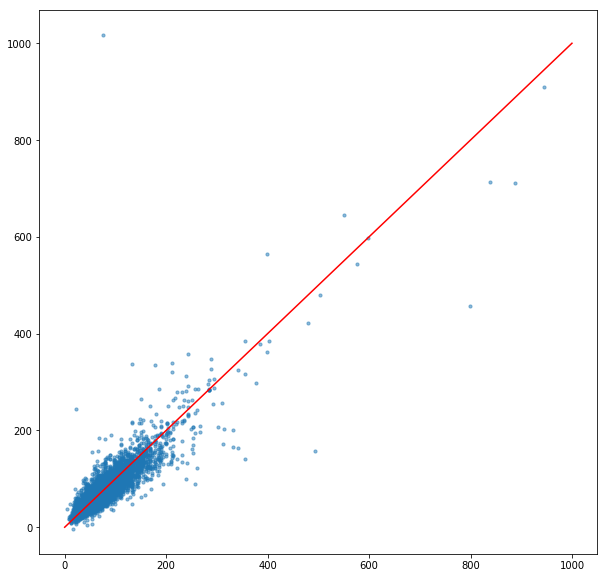

In [17]:
# 예측치와 실제 label 값 scatter. 기준선은 y=x
plt.figure(figsize =[10,10])
plt.scatter(y_test,y_predicted, marker ='o', s= 10, alpha = 0.5)
plt.plot([0,1000],[0,1000] ,c ='r')
plt.show()